In [264]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [265]:
#Data loading
client_data = pd.read_csv('/content/client_data.csv',parse_dates=['date_activ','date_end','date_modif_prod','date_renewal'])
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [266]:
price_data = pd.read_csv('/content/price_data.csv',parse_dates=['price_date'])
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


Feature Selection

In [267]:
mean_year=price_data.groupby(['id']).mean().reset_index()

In [268]:
mean_6m=price_data[price_data['price_date']>'2015-06-01'].groupby(['id']).mean().reset_index()

In [269]:
mean_3m=price_data[price_data['price_date']>'2015-10-01'].groupby(['id']).mean().reset_index()

In [270]:
#Combine the mean year in a single dataframe
mean_year=mean_year.rename(index=str,columns={'price_off_peak_var':'mean_year_price_p1_var',
                                              'price_peak_var':'mean_year_price_p2_var',
                                              'price_mid_peak_var':'mean_year_price_p3_var',
                                              'price_off_peak_fix':'mean_year_price_p1_fix',
                                              'price_peak_fix':'mean_year_price_p2_fix',
                                              'price_mid_peak_fix':'mean_year_price_p3_fix',})
mean_year['mean_year_price_p1']=mean_year['mean_year_price_p1_var']+mean_year['mean_year_price_p1_fix']
mean_year['mean_year_price_p2']=mean_year['mean_year_price_p2_var']+mean_year['mean_year_price_p2_fix']
mean_year['mean_year_price_p3']=mean_year['mean_year_price_p3_var']+mean_year['mean_year_price_p3_fix']

In [271]:
mean_6m=mean_6m.rename(index=str,columns={'price_off_peak_var':'mean_6m_price_p1_var',
                                              'price_peak_var':'mean_6m_price_p2_var',
                                              'price_mid_peak_var':'mean_6m_price_p3_var',
                                              'price_off_peak_fix':'mean_6m_price_p1_fix',
                                              'price_peak_fix':'mean_6m_price_p2_fix',
                                              'price_mid_peak_fix':'mean_6m_price_p3_fix',})
mean_6m['mean_6m_price_p1']=mean_6m['mean_6m_price_p1_var']+mean_6m['mean_6m_price_p1_fix']
mean_6m['mean_6m_price_p2']=mean_6m['mean_6m_price_p2_var']+mean_6m['mean_6m_price_p2_fix']
mean_6m['mean_6m_price_p3']=mean_6m['mean_6m_price_p3_var']+mean_6m['mean_6m_price_p3_fix']

In [272]:
mean_3m=mean_3m.rename(index=str,columns={'price_off_peak_var':'mean_3m_price_p1_var',
                                              'price_peak_var':'mean_3m_price_p2_var',
                                              'price_mid_peak_var':'mean_3m_price_p3_var',
                                              'price_off_peak_fix':'mean_3m_price_p1_fix',
                                              'price_peak_fix':'mean_3m_price_p2_fix',
                                              'price_mid_peak_fix':'mean_3m_price_p3_fix',})
mean_3m['mean_3m_price_p1']=mean_3m['mean_3m_price_p1_var']+mean_3m['mean_3m_price_p1_fix']
mean_3m['mean_3m_price_p2']=mean_3m['mean_3m_price_p2_var']+mean_3m['mean_3m_price_p2_fix']
mean_3m['mean_3m_price_p3']=mean_3m['mean_3m_price_p3_var']+mean_3m['mean_3m_price_p3_fix']

In [273]:
price_data_new = pd.merge(mean_year,mean_6m, on='id',how='left')
price_data_new = pd.merge(mean_year,mean_3m, on='id',how='left')
price_data_new.head()

,id,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555,40.848791,24.539003,16.365274
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000,0.143943,0.000000,0.000000,44.444710,0.00000,0.000000,44.588653,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000,0.201280,0.000000,0.000000,45.944710,0.00000,0.000000,46.145990,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003,0.113068,0.095385,0.069409,40.728885,24.43733,16.291555,40.841953,24.532715,16.360964
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000,0.145440,0.000000,0.000000,44.266930,0.00000,0.000000,44.412370,0.000000,0.000000


In [274]:
#Extract contract duration 
#we will define the duration=date_end-date_activ
client_data['contract_duration']=((client_data['date_end']-client_data['date_activ'])/ np.timedelta64(1,'M')).astype(int)
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_duration
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,36
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,84
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,72
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,72
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,73


In [275]:
#set the reference time to be 2016-01-01
#write a finction to caculate the month difference between datetime features
def calculatemonth(referencetime,dataframe,column):
    time_diff=referencetime-dataframe[column]
    months=(time_diff/np.timedelta64(1,'M')).astype(int)
    return months

In [276]:
referencetime=pd.to_datetime('2016-01-01')

In [277]:
client_data['activ_diff']=calculatemonth(referencetime,client_data,'date_activ')
client_data['end_diff']=calculatemonth(referencetime,client_data,'date_end')
client_data['modif_diff']=calculatemonth(referencetime,client_data,'date_modif_prod')
client_data['renewal_diff']=calculatemonth(referencetime,client_data,'date_renewal')
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,36,30,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,84,76,-7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,72,68,-3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,72,69,-2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,73,71,-2,71,9


In [278]:
#Remove the date columns 
client_data.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'],axis=1,inplace=True)
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,36,30,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,84,76,-7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,72,68,-3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,72,69,-2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,73,71,-2,71,9


Categorical Data

In [279]:
client_data.select_dtypes("object")

,id,channel_sales,has_gas,origin_up
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,t,lxidpiddsbxsbosboudacockeimpuepw
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
4,149d57cf92fc41cf94415803a877cb4b,MISSING,f,kamkkxfxxuwbdslkwifmmcsiusiuosws
...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,foosdfpfkusacimwkcsosbicdxkicaua,t,lxidpiddsbxsbosboudacockeimpuepw
14602,d0a6f71671571ed83b2645d23af6de00,foosdfpfkusacimwkcsosbicdxkicaua,f,lxidpiddsbxsbosboudacockeimpuepw
14603,10e6828ddd62cbcf687cb74928c4c2d2,foosdfpfkusacimwkcsosbicdxkicaua,f,lxidpiddsbxsbosboudacockeimpuepw
14604,1cf20fd6206d7678d5bcafd28c53b4db,foosdfpfkusacimwkcsosbicdxkicaua,f,lxidpiddsbxsbosboudacockeimpuepw


In [280]:
client_data.channel_sales.value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [281]:
# encoding "channel_sales" Column
client_data.replace({'channel_sales':{'MISSING':0,'fixdbufsefwooaasfcxdxadsiekoceaa':1, 'epumfxlbckeskwekxbiuasklxalciiuu':2,'sddiedcslfslkckwlfkdpoeeailfpeds':3, 'ewpakwlliwisiwduibdlfmalxowmwpci':4, 'usilxuppasemubllopkaafesmlibmsdf':5, 'lmkebamcaaclubfxadlmueccxoimlema':6, 'foosdfpfkusacimwkcsosbicdxkicaua':7}},inplace=True)

In [282]:
client_data.origin_up.value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [283]:
# encoding "origin_up" Column
client_data.replace({'origin_up':{'MISSING':0,'ewxeelcelemmiwuafmddpobolfuxioce':1,'usapbepcfoloekilkwsdiboslwaxobdp':2, 'ldkssxwpmemidmecebumciepifcamkci':3, 'kamkkxfxxuwbdslkwifmmcsiusiuosws':4, 'lxidpiddsbxsbosboudacockeimpuepw':5}},inplace=True)



In [284]:
client_data.has_gas.value_counts()

f    11955
t     2651
Name: has_gas, dtype: int64

In [285]:
# encoding "has_gas" Column
client_data.replace({'has_gas':{'f':0,'t':1}},inplace=True)

Numerical Data Distribution

From the previous EDA we can see that some features are highly skewed, we need to transform the distribution to normal-like distribution

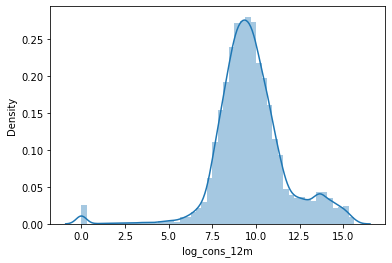

In [286]:
#First for the cons_12, apply a log tranformation
client_data['log_cons_12m']=client_data['cons_12m'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_cons_12m']);

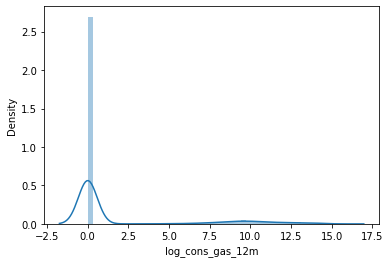

In [287]:
client_data['log_cons_gas_12m']=client_data['cons_gas_12m'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_cons_gas_12m']);

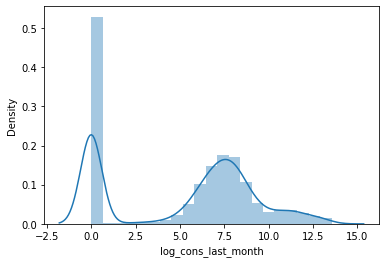

In [288]:
client_data['log_cons_last_month']=client_data['cons_last_month'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_cons_last_month']);

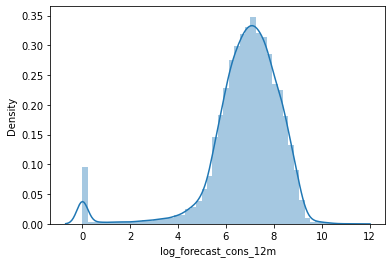

In [289]:
client_data['log_forecast_cons_12m']=client_data['forecast_cons_12m'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_forecast_cons_12m']);

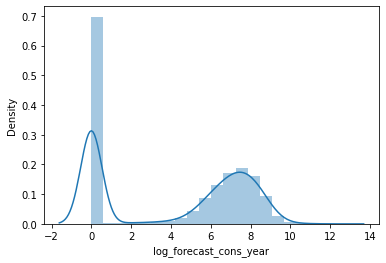

In [290]:
client_data['log_forecast_cons_year']=client_data['forecast_cons_year'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_forecast_cons_year']);

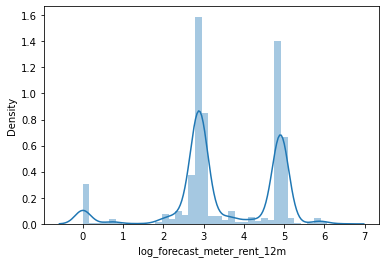

In [291]:
client_data['log_forecast_meter_rent_12m']=client_data['forecast_meter_rent_12m'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_forecast_meter_rent_12m'])

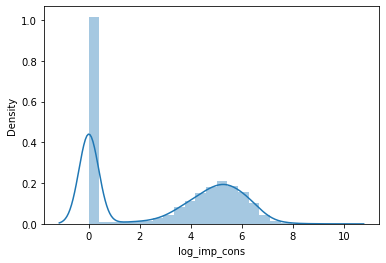

In [292]:
client_data['log_imp_cons']=client_data['imp_cons'].apply(lambda x:np.log(1+x))
sns.distplot(client_data['log_imp_cons']);

In [293]:
client_data=client_data.drop(['cons_12m','cons_gas_12m','cons_last_month','forecast_cons_12m','forecast_cons_year','forecast_meter_rent_12m','imp_cons'],axis=1)
client_data.head()

,id,channel_sales,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons
0,24011ae4ebbe3035111d65fa7c15bc57,7,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,3,5,43.648,1,36,30,-5,2,6,0.000000,10.914124,0.000000,0.000000,0.000000,1.022451,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,0,0.0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,6,4,13.800,0,84,76,-7,76,4,8.446985,0.000000,0.000000,5.252012,0.000000,2.848971,0.000000
2,764c75f661154dac3a6c254cd082ea7d,7,0.0,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,6,4,13.856,0,72,68,-3,68,8,6.300786,0.000000,0.000000,3.891004,0.000000,3.681855,0.000000
3,bba03439a292a1e166f80264c16191cb,6,0.0,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,6,4,13.200,0,72,69,-2,69,9,7.368340,0.000000,0.000000,5.484963,0.000000,3.036394,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,0.0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,6,4,19.800,0,73,71,-2,71,9,8.395252,0.000000,6.267201,6.101999,6.267201,4.888317,3.976311


In [294]:
#Calculate correlation of variables
corr_price_data=price_data_new.corr()

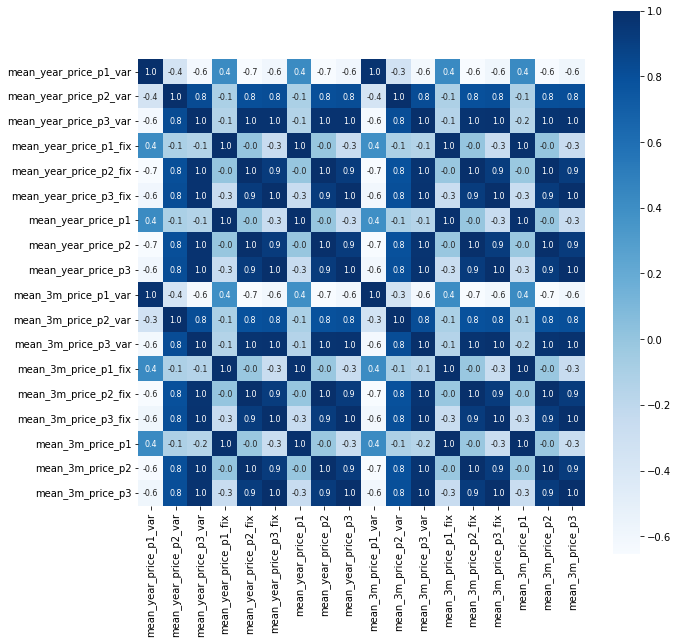

In [295]:
# constructing a heatmap to understand the correlation

plt.figure(figsize=(10,10))
sns.heatmap(corr_price_data, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [296]:
corr_client_data=client_data.corr()

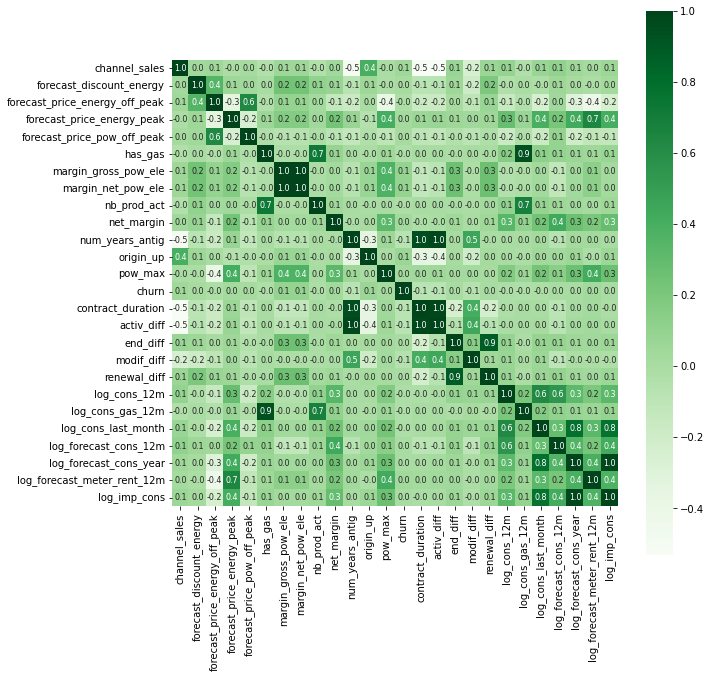

In [297]:
# constructing a heatmap to understand the correlation
plt.figure(figsize=(10,10))
sns.heatmap(corr_client_data, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Greens')

In [298]:
#num_years_antig has a high correlation with activ_diff, we can remove the num_years_antig since they are provides the same information.
client_data.drop(columns=['num_years_antig'],inplace=True)

Removing Outliers

In [301]:
#replace these outliers with the mean.
#IQR method to detect outliers
def remove_outliers(df,col):
    df.loc[df[col]<0,col]=df[col].mean()
    q1=df[col].quantile(.25)
    q3=df[col].quantile(.75)
    iqr=q3-q1
    upper_bound=q3+(iqr*1.5)
    lower_bound=q1-(iqr*1.5)
    df=df[(lower_bound<df[col])|(df[col]<upper_bound)]

In [302]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  int64  
 2   forecast_discount_energy        14606 non-null  float64
 3   forecast_price_energy_off_peak  14606 non-null  float64
 4   forecast_price_energy_peak      14606 non-null  float64
 5   forecast_price_pow_off_peak     14606 non-null  float64
 6   has_gas                         14606 non-null  int64  
 7   margin_gross_pow_ele            14606 non-null  float64
 8   margin_net_pow_ele              14606 non-null  float64
 9   nb_prod_act                     14606 non-null  int64  
 10  net_margin                      14606 non-null  float64
 11  origin_up                       14606 non-null  int64  
 12  pow_max                         

In [303]:
remove_outliers(price_data_new,'mean_year_price_p1_var')
remove_outliers(price_data_new,'mean_year_price_p2_var')
remove_outliers(price_data_new,'mean_year_price_p3_var')
remove_outliers(price_data_new,'mean_year_price_p1_fix')
remove_outliers(price_data_new,'mean_year_price_p2_fix')
remove_outliers(price_data_new,'mean_year_price_p3_fix')
remove_outliers(price_data_new,'mean_year_price_p1')
remove_outliers(price_data_new,'mean_year_price_p2')
remove_outliers(price_data_new,'mean_year_price_p3')
remove_outliers(client_data,'log_cons_12m')
remove_outliers(client_data,'log_cons_gas_12m')
remove_outliers(client_data,'log_cons_last_month')
remove_outliers(client_data,'log_forecast_cons_12m')
remove_outliers(client_data,'log_forecast_meter_rent_12m')
remove_outliers(client_data,'log_forecast_cons_year')
remove_outliers(client_data,'log_imp_cons')
remove_outliers(client_data,'forecast_discount_energy')
remove_outliers(client_data,'forecast_price_energy_off_peak')
remove_outliers(client_data,'forecast_price_energy_peak')
remove_outliers(client_data,'forecast_price_pow_off_peak')
remove_outliers(client_data,'margin_gross_pow_ele')
remove_outliers(client_data,'margin_net_pow_ele')
remove_outliers(client_data,'net_margin')
remove_outliers(client_data,'pow_max')


Data set merging 

In [304]:
data = pd.merge(client_data, price_data_new, on='id', how = 'left')
data.head()

,id,channel_sales,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,origin_up,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,24011ae4ebbe3035111d65fa7c15bc57,7,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,5,43.648,1,36,30,-5,2,6,0.000000,10.914124,0.000000,0.000000,0.000000,1.022451,0.000000,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687
1,d29c2c54acc38ff3c0614d0a653813dd,0,0.0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,4,13.800,0,84,76,-7,76,4,8.446985,0.000000,0.000000,5.252012,0.000000,2.848971,0.000000,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,7,0.0,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,4,13.856,0,72,68,-3,68,8,6.300786,0.000000,0.000000,3.891004,0.000000,3.681855,0.000000,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000
3,bba03439a292a1e166f80264c16191cb,6,0.0,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,4,13.200,0,72,69,-2,69,9,7.368340,0.000000,0.000000,5.484963,0.000000,3.036394,0.000000,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,0,0.0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,4,19.800,0,73,71,-2,71,9,8.395252,0.000000,6.267201,6.101999,6.267201,4.888317,3.976311,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274


In [305]:
data.drop('id',axis=1,inplace=True)

In [306]:
data.shape

(14606, 43)

In [307]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   channel_sales                   14606 non-null  int64  
 1   forecast_discount_energy        14606 non-null  float64
 2   forecast_price_energy_off_peak  14606 non-null  float64
 3   forecast_price_energy_peak      14606 non-null  float64
 4   forecast_price_pow_off_peak     14606 non-null  float64
 5   has_gas                         14606 non-null  int64  
 6   margin_gross_pow_ele            14606 non-null  float64
 7   margin_net_pow_ele              14606 non-null  float64
 8   nb_prod_act                     14606 non-null  int64  
 9   net_margin                      14606 non-null  float64
 10  origin_up                       14606 non-null  int64  
 11  pow_max                         14606 non-null  float64
 12  churn                           

In [308]:
data.isnull().sum()

channel_sales                     0
forecast_discount_energy          0
forecast_price_energy_off_peak    0
forecast_price_energy_peak        0
forecast_price_pow_off_peak       0
has_gas                           0
margin_gross_pow_ele              0
margin_net_pow_ele                0
nb_prod_act                       0
net_margin                        0
origin_up                         0
pow_max                           0
churn                             0
contract_duration                 0
activ_diff                        0
end_diff                          0
modif_diff                        0
renewal_diff                      0
log_cons_12m                      0
log_cons_gas_12m                  0
log_cons_last_month               0
log_forecast_cons_12m             0
log_forecast_cons_year            0
log_forecast_meter_rent_12m       0
log_imp_cons                      0
mean_year_price_p1_var            0
mean_year_price_p2_var            0
mean_year_price_p3_var      

In [309]:
data=data.dropna()

In [310]:
data.head()



,channel_sales,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,origin_up,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,7,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,5,43.648,1,36,30,-5,2,6,0.000000,10.914124,0.000000,0.000000,0.000000,1.022451,0.000000,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687
1,0,0.0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,4,13.800,0,84,76,-7,76,4,8.446985,0.000000,0.000000,5.252012,0.000000,2.848971,0.000000,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000
2,7,0.0,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,4,13.856,0,72,68,-3,68,8,6.300786,0.000000,0.000000,3.891004,0.000000,3.681855,0.000000,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000
3,6,0.0,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,4,13.200,0,72,69,-2,69,9,7.368340,0.000000,0.000000,5.484963,0.000000,3.036394,0.000000,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000
4,0,0.0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,4,19.800,0,73,71,-2,71,9,8.395252,0.000000,6.267201,6.101999,6.267201,4.888317,3.976311,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274


In [ ]:
#data.to_csv('feature_engineering.csv', index = False)

Dependent (features) and Independent (target) Variables

In [311]:
x=data.drop('churn',axis=1)
y=data['churn']

In [312]:
x

,channel_sales,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,origin_up,pow_max,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,7,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,5,43.648,36,30,-5,2,6,0.000000,10.914124,0.000000,0.000000,0.000000,1.022451,0.000000,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687
1,0,0.0,0.145711,0.000000,44.311378,0,16.38,16.38,1,18.89,4,13.800,84,76,-7,76,4,8.446985,0.000000,0.000000,5.252012,0.000000,2.848971,0.000000,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000
2,7,0.0,0.165794,0.087899,44.311378,0,28.60,28.60,1,6.60,4,13.856,72,68,-3,68,8,6.300786,0.000000,0.000000,3.891004,0.000000,3.681855,0.000000,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000
3,6,0.0,0.146694,0.000000,44.311378,0,30.22,30.22,1,25.46,4,13.200,72,69,-2,69,9,7.368340,0.000000,0.000000,5.484963,0.000000,3.036394,0.000000,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000
4,0,0.0,0.116900,0.100015,40.606701,0,44.91,44.91,1,47.98,4,19.800,73,71,-2,71,9,8.395252,0.000000,6.267201,6.101999,6.267201,4.888317,3.976311,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,7,0.0,0.138305,0.000000,44.311378,1,27.88,27.88,2,381.77,5,15.000,47,43,-4,7,19,10.381924,10.777726,0.000000,8.444410,0.000000,2.973998,0.000000,0.144124,0.000000,0.000000,44.370635,0.000000,0.000000,44.514760,0.000000,0.000000,0.140172,0.000000,0.000000,44.444710,0.000000,0.000000,44.584882,0.000000,0.000000
14602,7,0.0,0.100167,0.091892,58.995952,0,0.00,0.00,1,90.34,5,6.000,48,40,-7,40,4,8.885164,0.000000,5.204007,6.449981,5.204007,4.976941,2.829678,0.106799,0.095406,0.070817,59.015674,36.393379,8.345418,59.122473,36.488785,8.416235,0.102352,0.093181,0.070990,59.173468,36.490689,8.367731,59.275820,36.583870,8.438721
14603,7,0.0,0.116900,0.100015,40.606701,0,39.84,39.84,1,20.38,5,15.935,47,46,-1,46,10,7.520235,0.000000,5.192957,5.254313,5.192957,4.872139,2.947067,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274
14604,7,0.0,0.145711,0.000000,44.311378,0,13.08,13.08,1,0.96,5,11.000,48,40,-7,40,4,4.882802,0.000000,0.000000,3.012589,0.000000,2.101692,0.000000,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000


In [313]:
y

0        1
1        0
2        0
3        0
4        0
        ..
14601    0
14602    1
14603    1
14604    0
14605    0
Name: churn, Length: 14605, dtype: int64

Standardize the data

In [314]:
scaler = StandardScaler()

In [315]:
x_std=scaler.fit_transform(x)

In [316]:
x_std

array([[ 0.79244833, -0.18919653, -0.92602391, ..., -0.12123118,
         0.22796782,  0.25915381],
       [-1.63187254, -0.18919653,  0.3423538 , ...,  0.29780691,
        -0.78292884, -0.78108125],
       [ 0.79244833, -0.18919653,  1.15800636, ...,  0.30211932,
        -0.77566947, -0.78108125],
       ...,
       [ 0.79244833, -0.18919653, -0.82777845, ..., -0.50145931,
         1.23199965,  1.29937615],
       [ 0.79244833, -0.18919653,  0.3423538 , ...,  0.29780691,
        -0.78292884, -0.78108125],
       [-1.63187254, -0.18919653,  1.21047975, ...,  0.2637701 ,
        -0.77579296, -0.78108125]])

In [317]:
x_std.std()

1.0

Splitting the data into training data and test data

In [318]:
X_train, X_test, Y_train, Y_test = train_test_split(x_std, y, test_size=0.2, stratify=y,random_state=0)

In [319]:
X_train.shape

(11684, 42)

In [320]:
X_test.shape

(2921, 42)

In [321]:
Y_train.shape

(11684,)

In [322]:
Y_test.shape

(2921,)

 Model training: Logistic Regression

In [323]:
model1 = LogisticRegression()

In [324]:
model1.fit(X_train, Y_train)

LogisticRegression()

Model Evaluation

In [325]:
# accuracy score on the training data
X_train_prediction = model1.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [326]:
print(training_data_accuracy)

0.9024306744265662


In [327]:
# accuracy score on the test data
X_test_prediction = model1.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [328]:
print(test_data_accuracy)

0.9020883259157823


In [329]:
confusion_matrix(X_test_prediction, Y_test)

array([[2635,  284],
       [   2,    0]])

Model training2: RandomForestClassifier

In [330]:
model2= RandomForestClassifier(n_estimators=100)

In [331]:
model2.fit(X_train, Y_train)

RandomForestClassifier()

Model Evaluation

In [332]:
# accuracy score on the training data
X_train_prediction = model2.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print(test_data_accuracy)

0.9020883259157823


In [333]:
# accuracy score on the test data
X_test_prediction = model2.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print(test_data_accuracy)

0.9096199931530298


In [334]:
confusion_matrix(X_test_prediction, Y_test)

array([[2636,  263],
       [   1,   21]])

Model Training3 : XGBoost Classifier

In [335]:
model3 = XGBClassifier()

In [336]:
model3.fit(X_train, Y_train)

XGBClassifier()

Model Evaluation

In [337]:
# accuracy score on the training data
X_train_prediction = model3.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print(test_data_accuracy)

0.9096199931530298


In [338]:
# accuracy score on the test data
X_test_prediction = model3.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print(test_data_accuracy)

0.9031153714481343


In [339]:
confusion_matrix(X_test_prediction, Y_test)

array([[2637,  283],
       [   0,    1]])